<a href="https://colab.research.google.com/github/AsgerIpsen1/workshop-2/blob/main/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regnvands simulering

jeg vil gerne simulere og visualisere, hvordan et skybrud vil pårvirke RUCs infrastruktur. Dette skal visualiseres gennem bluespots og skal på samme tid simuleres gennem historisk data fra et skybrud.

Først er der simuleret konstant regn over RUC, hvor hver time i døgnet er påvirket. Herefter er der hentet data fra, hvor simuleringen går efter historisk data.

Modellen er i første omgang sat til at det skal regne 10cm i timen.

Vores lærer har lavet tærren datan for os, mens vi selv har lavet resten af kodningen.



In [10]:
!pip install rasterio # rasterio is not installed on colab

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import requests
from io import BytesIO

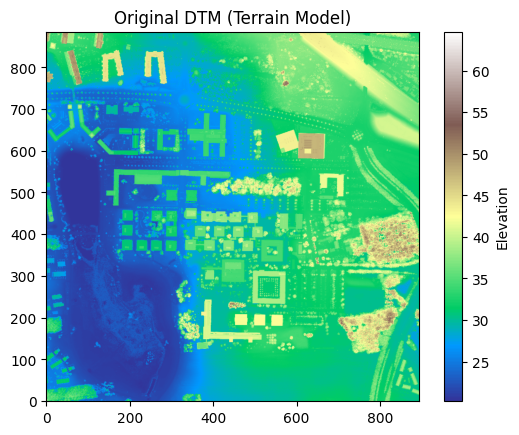

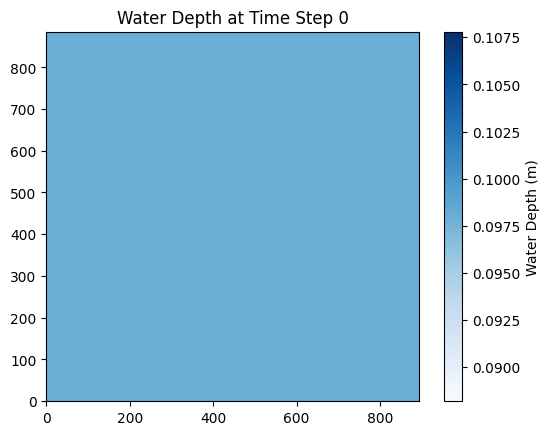

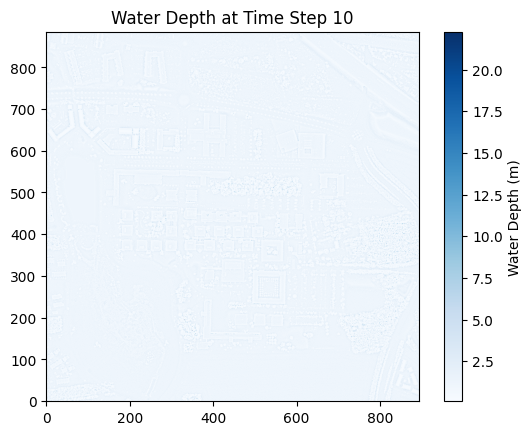

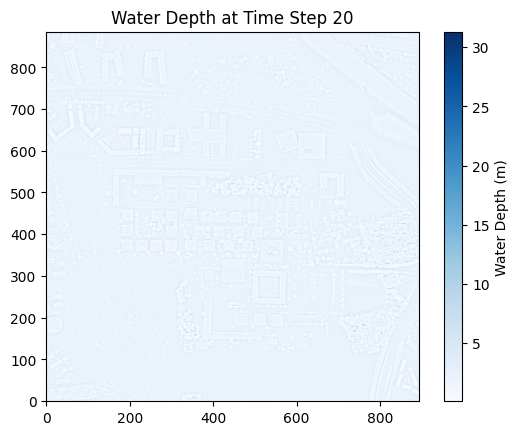

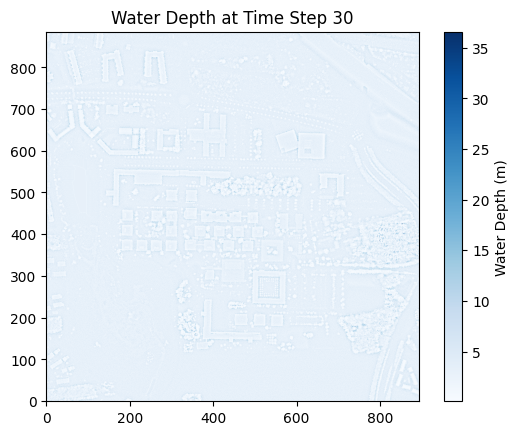

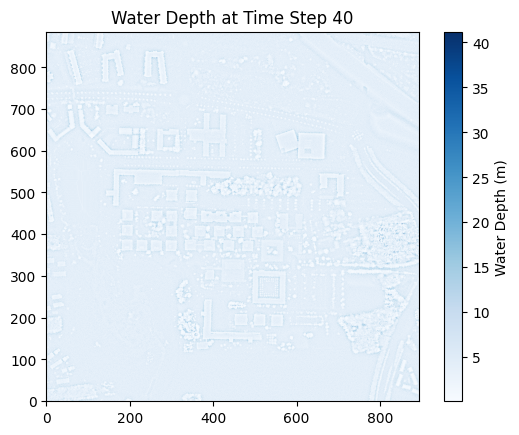

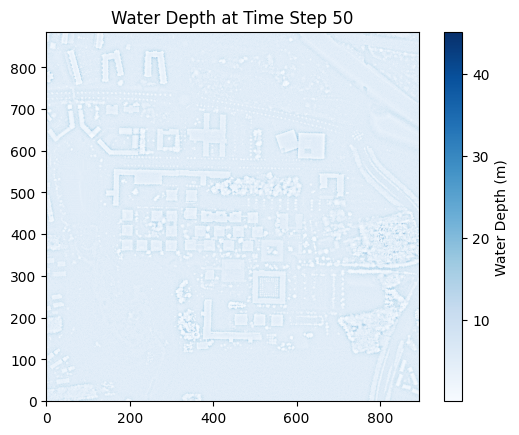

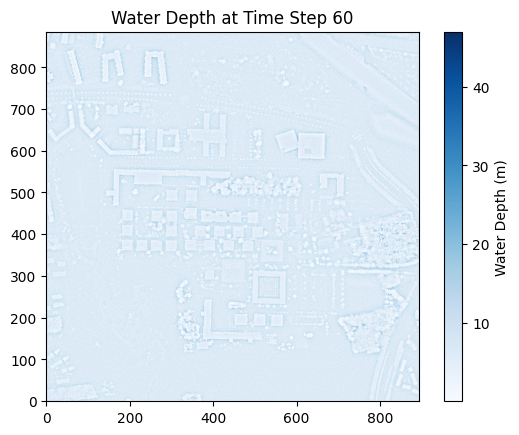

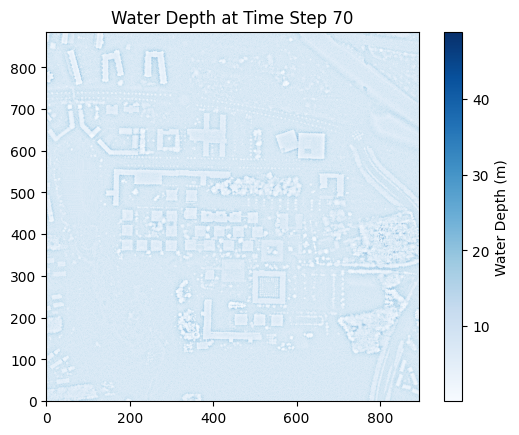

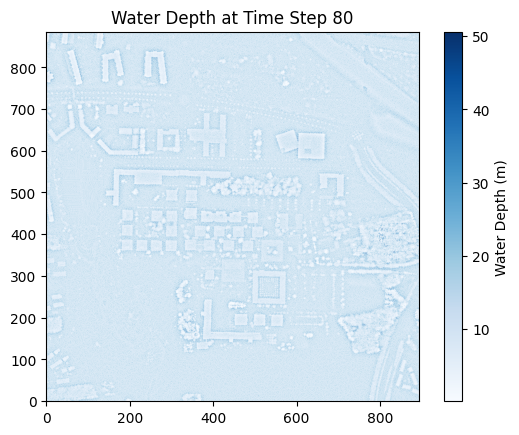

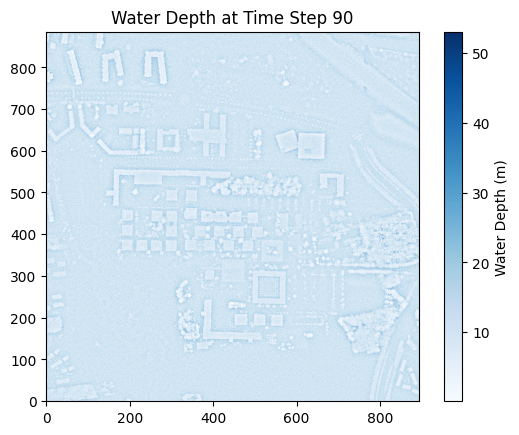

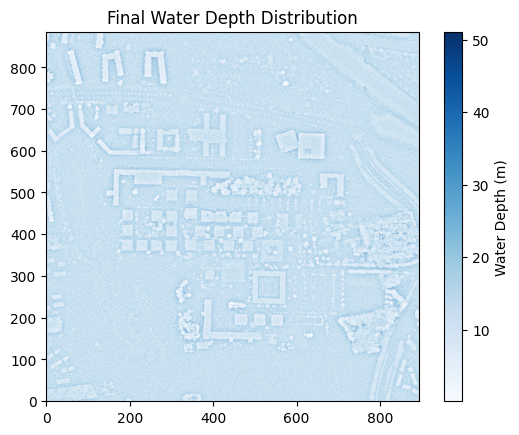

In [12]:
# -------------------------------
# GRID INITIALIZATION
# -------------------------------

# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dtm = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

# Store the original DTM for visualization
original_dtm = np.copy(dtm)

nx, ny = dtm.shape  # Dimensions of the grid
# Initialize a grid for water depth (initially zero everywhere)
water_depth = np.zeros((nx, ny))

# -------------------------------
# INPUT PARAMETERS
# -------------------------------

# Rainfall per timestep (uniform rain over the grid)
rainfall = np.full((nx, ny), 0.1)  # 1 cm of rain per timestep

# Infiltration per timestep (constant for all cells)
infiltration = np.full((nx, ny), 0.002)  # 2 mm infiltration per timestep

# Number of timesteps for simulation
timesteps = 100

# -------------------------------
# NEIGHBOR IDENTIFICATION FUNCTION
# -------------------------------

def get_neighbors(i, j):
    """
    Returns the neighboring cell indices (north, south, west, east) if within bounds.
    """
    neighbors = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # N, S, W, E
        ni, nj = i + di, j + dj
        if 0 <= ni < nx and 0 <= nj < ny:
            neighbors.append((ni, nj))
    return neighbors

# -------------------------------
# VISUALIZE ORIGINAL DTM
# -------------------------------
plt.imshow(original_dtm, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation")
plt.title("Original DTM (Terrain Model)")
plt.show()

# -------------------------------
# SIMULATION LOOP
# -------------------------------

# Iterate over multiple timesteps to model water accumulation and flow
for t in range(timesteps):
    # Create a new water depth grid for the next timestep
    new_water_depth = np.copy(water_depth)

    # Step 1: Add Rainfall to each cell
    new_water_depth += rainfall

    # Step 2: Apply Infiltration (cannot infiltrate more water than available in the cell)
    new_water_depth -= np.minimum(new_water_depth, infiltration)

    # Step 3: Compute Flow Between Neighboring Cells
    for i in range(nx):
        for j in range(ny):
            # Calculate the total height (terrain + water depth)
            cell_elevation = dtm[i, j] + water_depth[i, j]
            neighbors = get_neighbors(i, j)

            # Identify possible outflow to lower neighbors
            total_flow = 0
            flow_out = []
            for ni, nj in neighbors:
                neighbor_elevation = dtm[ni, nj] + water_depth[ni, nj]
                if cell_elevation > neighbor_elevation:  # Only flow downhill
                    flow_amount = (cell_elevation - neighbor_elevation) * 0.1  # Simplified flow formula
                    total_flow += flow_amount
                    flow_out.append((ni, nj, flow_amount))

            # Distribute Flow Proportionally
            if total_flow > 0:
                for ni, nj, flow_amount in flow_out:
                    transfer_amount = (flow_amount / total_flow) * water_depth[i, j]  # Ensure conservation of mass
                    new_water_depth[i, j] -= transfer_amount
                    new_water_depth[ni, nj] += transfer_amount

    # Update water depth for the next timestep
    water_depth = new_water_depth

    # -------------------------------
    # VISUALIZATION
    # -------------------------------
    if t % 10 == 0:  # Update visualization every 10 timesteps
        plt.imshow(water_depth, cmap="Blues", origin="lower")
        plt.colorbar(label="Water Depth (m)")
        plt.title(f"Water Depth at Time Step {t}")
        plt.show()

# Final visualization
plt.imshow(water_depth, cmap="Blues", origin="lower")
plt.colorbar(label="Water Depth (m)")
plt.title("Final Water Depth Distribution")
plt.show()

# Fremgangsmåde

vi starter med at importere de biblioteker biblioteker vi gerne vil bruge

```python
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import requests
from io import BytesIO
```

for at indlæse en tiff bruger vi disse koder

```Python
# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dtm = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

# Store the original DTM for visualization
original_dtm = np.copy(dtm)

nx, ny = dtm.shape  # Dimensions of the grid

# Initialize a grid for water depth (initially zero everywhere)
water_depth = np.zeros((nx, ny))
```



derefter definere bi de forskellige paramenter som skal bruges i koden:

```python

rainfall = np.full((nx, ny), 0.01)  # 1 cm of rain per timestep


infiltration = np.full((nx, ny), 0.002)  # 2 mm infiltration per timestep

timesteps = 100
```

Derefter definere vi, nabocellen
```python
def get_neighbors(i, j):
    """
    Returns the neighboring cell indices (north, south, west, east) if within bounds.
    """
    neighbors = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # N, S, W, E
        ni, nj = i + di, j + dj
        if 0 <= ni < nx and 0 <= nj < ny:
            neighbors.append((ni, nj))
    return neighbors
    ```
nabocellerne bruges til at definere, hvor vandet flyder hen
hverfelt i vores animation er en nabo - en nabo tjekker op på sine nabober (op ned højre venstre) for at se, hvor vandet flyder hen.

her visualisere vi dtm cellen:
```python
plt.imshow(original_dtm, cmap="terrain", origin="lower")
plt.colorbar(label="Elevation")
plt.title("Original DTM (Terrain Model)")
plt.show()
```


Herefter skal selve simulerings loopet laves - loopet viser, hvordan vandet placere sig over flere skridt:

```python

# Iterate over multiple timesteps to model water accumulation and flow
for t in range(timesteps):
    # Create a new water depth grid for the next timestep
    new_water_depth = np.copy(water_depth)

    # Step 1: Add Rainfall to each cell
    new_water_depth += rainfall

    # Step 2: Apply Infiltration (cannot infiltrate more water than available in the cell)
    new_water_depth -= np.minimum(new_water_depth, infiltration)

    # Step 3: Compute Flow Between Neighboring Cells
    for i in range(nx):
        for j in range(ny):
            # Calculate the total height (terrain + water depth)
            cell_elevation = dtm[i, j] + water_depth[i, j]
            neighbors = get_neighbors(i, j)

            # Identify possible outflow to lower neighbors
            total_flow = 0
            flow_out = []
            for ni, nj in neighbors:
                neighbor_elevation = dtm[ni, nj] + water_depth[ni, nj]
                if cell_elevation > neighbor_elevation:  # Only flow downhill
                    flow_amount = (cell_elevation - neighbor_elevation) * 0.1  # Simplified flow formula
                    total_flow += flow_amount
                    flow_out.append((ni, nj, flow_amount))

            # Distribute Flow Proportionally
            if total_flow > 0:
                for ni, nj, flow_amount in flow_out:
                    transfer_amount = (flow_amount / total_flow) * water_depth[i, j]  # Ensure conservation of mass
                    new_water_depth[i, j] -= transfer_amount
                    new_water_depth[ni, nj] += transfer_amount

    # Update water depth for the next timestep
    water_depth = new_water_dept`
  
```
- tilføje regnt til hver celle
- anvende infiltration så noget af vandet forsvinder
- bregne vandflow mellem naboceller
- Fordele vandets propotionalitet
- opdele vanddybden


Dette skaber visualiseringen

```python
if t % 10 == 0:  # Update visualization every 10 timesteps
        plt.imshow(water_depth, cmap="Blues", origin="lower")
        plt.colorbar(label="Water Depth (m)")
        plt.title(f"Water Depth at Time Step {t}")
        plt.show()

# Final visualization
plt.imshow(water_depth, cmap="Blues", origin="lower")
plt.colorbar(label="Water Depth (m)")
plt.title("Final Water Depth Distribution")
plt.show()
```


for at indlæse en tiff fil gør jeg:


In [ ]:
´´´python
# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dtm = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

# Store the original DTM for visualization
original_dtm = np.copy(dtm)

# Initialize a grid for water depth (initially zero everywhere)
water_depth = np.zeros((nx, ny))

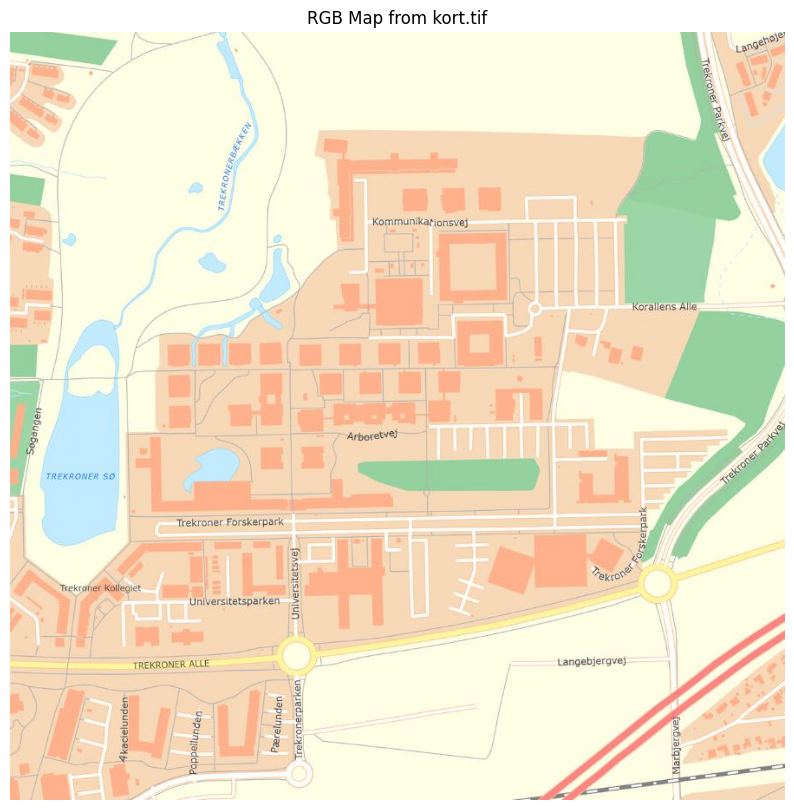

In [ ]:
# URL of the raw TIFF file on GitHub
url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/kort.tif"

# Download the file
response = requests.get(url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    # Read all bands (assuming RGB)
    img = src.read()  # Shape: (Bands, Height, Width)

    # Convert to (Height, Width, Bands) for display
    img = np.moveaxis(img, 0, -1)

    # Normalize the pixel values (if needed)
    if img.dtype == np.uint16:  # If 16-bit image
        img = img / 65535.0
    elif img.dtype == np.uint8:  # If 8-bit image
        img = img / 255.0

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.title("RGB Map from kort.tif")
    plt.show()

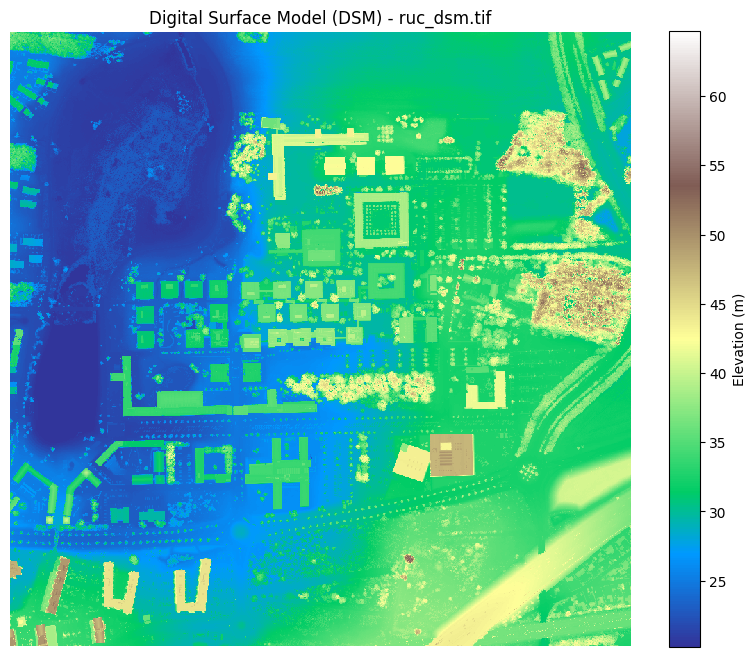

DSM Shape: (886, 894)
Sample values: [[36.933327 37.27649  37.104797 36.769432 34.94154 ]
 [34.17551  38.303276 36.976093 37.068638 36.297283]
 [36.547215 36.48035  37.63134  38.205524 37.163994]
 [36.54455  35.358944 36.59813  37.875797 37.06484 ]
 [36.342663 36.2809   36.82617  35.51138  36.99096 ]]


In [ ]:
# URL of the DSM file (raw file link from GitHub)
dsm_url = "https://raw.githubusercontent.com/Esbern/Python-for-Planners/main/data/ruc_dsm.tif"

# Download the file
response = requests.get(dsm_url)
tif_data = BytesIO(response.content)

# Open the TIFF file with rasterio
with rasterio.open(tif_data) as src:
    dsm_array = src.read(1)  # Read the first (and likely only) band as a NumPy array
    profile = src.profile  # Store metadata (e.g., resolution, CRS)

# Plot the DSM as a grayscale image
plt.figure(figsize=(10, 8))
plt.imshow(dsm_array, cmap="terrain", interpolation="nearest")  # "terrain" colormap for elevation
plt.colorbar(label="Elevation (m)")
plt.title("Digital Surface Model (DSM) - ruc_dsm.tif")
plt.axis("off")
plt.show()

# Print array shape and sample values
print("DSM Shape:", dsm_array.shape)
print("Sample values:", dsm_array[0:5, 0:5])  # Print a small 5x5 section

Min elevation: 20.212818
Max elevation: 64.70364


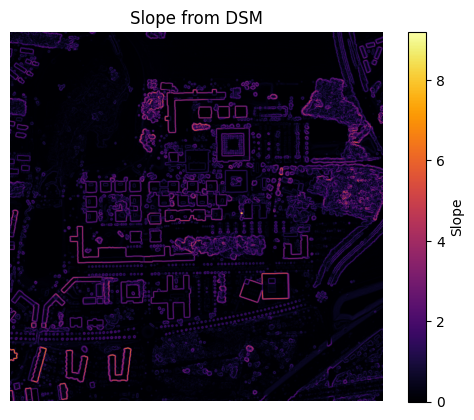

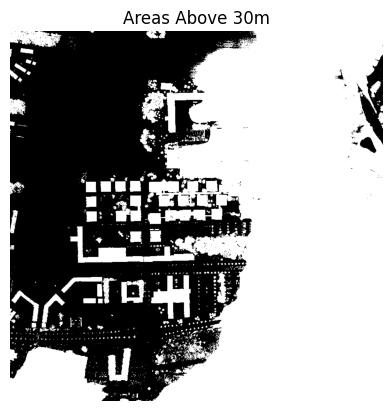

In [ ]:
print("Min elevation:", np.min(dsm_array))
print("Max elevation:", np.max(dsm_array))

#Calculate slope (approximation):

from scipy.ndimage import gaussian_gradient_magnitude

slope = gaussian_gradient_magnitude(dsm_array, sigma=1)  # Approximate slope calculation
plt.imshow(slope, cmap="inferno")
plt.colorbar(label="Slope")
plt.title("Slope from DSM")
plt.axis("off")
plt.show()

#Mask areas above a certain height (e.g., above 30m):

high_areas = dsm_array > 30
plt.imshow(high_areas, cmap="gray")
plt.title("Areas Above 30m")
plt.axis("off")
plt.show()